**Chapter 15 - Processing Sequences Using RNNs and CNNs**

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow >= 2.8:

In [2]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Let's create the `images/rnn` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [4]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "rnn"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

# Basic RNNs

Each recurrent neuron has two sets of weights: one for the inputs $\mathbf{x}_{(t)}$ and the other for the outputs of the previous time step, $\mathbf{\hat{y}_{(t-1)}}$. Let's call these weight vectors $\mathbf{w_x}$ and $\mathbf{w_{\hat{y}}}$. If we consider the whole recurrent layer instead of just one recurrent layer instead of just one recurrent neuron, we can place all the weight vectors in two weight matrices: $\mathbf{W_x}$ and $\mathbf{W_{\hat{y}}}$

The output vector of the whole recurrent layer can then be computed as given below, where $\mathbf{b}$ is the bias vector and $\phi(.)$ is the activation function.

_Output of a recurrent layer for a single instance_

$\hat{y}_{(t)} = \phi(\mathbf{W_x}^T\mathbf{x}_{(t)} + \mathbf{W_{\hat{y}}}^T\mathbf{\hat{y}_{(t-1)}} + \mathbf{b})$

Just as with feedforward neural networks, we can compute a recurrent layer's output in one shot for an entire mini-batch by placing all the inputs at time step _t_ into an input matrix $\mathbf{X}_{(t)}$

_Outputs of a layer of recurrent neurons for all instances in a pass:_

$$\mathbf{\hat{Y}_{(t)}} = \phi(\mathbf{X}_{(t)}\mathbf{X}_x + \mathbf{\hat{Y}}_{(t-1)}\mathbf{W}_{\hat{y}} + \mathbf{b})
                        = \phi(\begin{bmatrix} \mathbf{X}_{(t)} && \mathbf{\hat{Y}}_{(t-1)} \end{bmatrix} \mathbf{W} + \mathbf{b})$$ 
with $$\mathbf{W} = \begin{bmatrix} W_x \\ W_y \end{bmatrix}$$

In this equation:
* $\hat{\mathbf{Y}}_{(t)}$ is an $m \times n_{neurons}$ matrix containing the layer's outputs at time step _t_ for each instance in the mini-batch (_m_ is the number of instances in the mini-batch and $n_{neurons}$ is the number of neurons).
* $X_{(t)}$ is an $m \times n_{neurons}$ matrix containing the inputs for all instances ($n_{inputs}$ is the number of input features).
* $\mathbf{W}_x$ is $n_{inputs} \times n_{neurons}$ matrix containing the connection weights for the outputs of the previous time step.
* $\mathbf{b}$ is a vector of size $n_{neurons}$ containing each neuron's bias term.
* The weight matrices $\mathbf{W}_x$ and $\mathbf{W}_{\hat{y}}$ are often concatenated vertically into a single weight matrix of shape $(n_{inputs} + n_{neurons}) \times n_{neurons}$
* The notation $\begin{bmatrix} \mathbf{X}_{(t)} && \mathbf{\hat{Y}}_{(t-1)} \end{bmatrix}$ represents the horizontal concatenation of the matrices $\mathbf{X}_{(t)}$ and $\mathbf{\hat{Y}}_{(t-1)}$

Let's download the ridership data from the ageron/data project. It originally comes from Chicago's Transit Authority, and was downloaded from the [Chicago's Data Portal](https://homl.info/ridership).

In [6]:
tf.keras.utils.get_file(
    "ridership.tgz",
    "https://github.com/ageron/data/raw/main/ridership.tgz",
    cache_dir=".",
    extract=True
)

'.\\datasets\\ridership.tgz'

In [7]:
import pandas as pd
from pathlib import Path

path = Path("datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals.csv")
df = pd.read_csv(path, parse_dates=["service_date"])
df.columns = ["date", "day_type", "bus", "rail", "total"]  # shorter names
df = df.sort_values("date").set_index("date")
df = df.drop("total", axis=1)  # no need for total, it's just bus + rail
df = df.drop_duplicates()  # remove duplicated months (2011-10 and 2014-07)

In [8]:
df.head()

,day_type,bus,rail
date,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


The `day_type` column contains `W` for **W**eekdays, `A` for S**a**turdays, and `U` for S**u**ndays or holidays.

Let's look at the first few months of 2019 (note tha Pandas treats the range boundaries as inclusive):

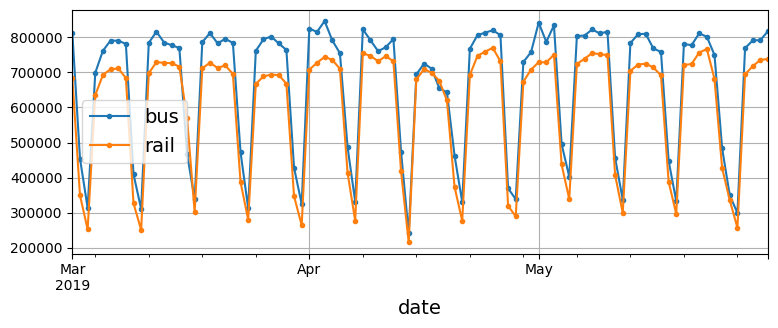

In [9]:
import matplotlib.pyplot as plt

df["2019-03":"2019-05"].plot(grid=True, marker=".", figsize=(8, 3.5))
save_fig("daily_ridership_plot")
plt.show()

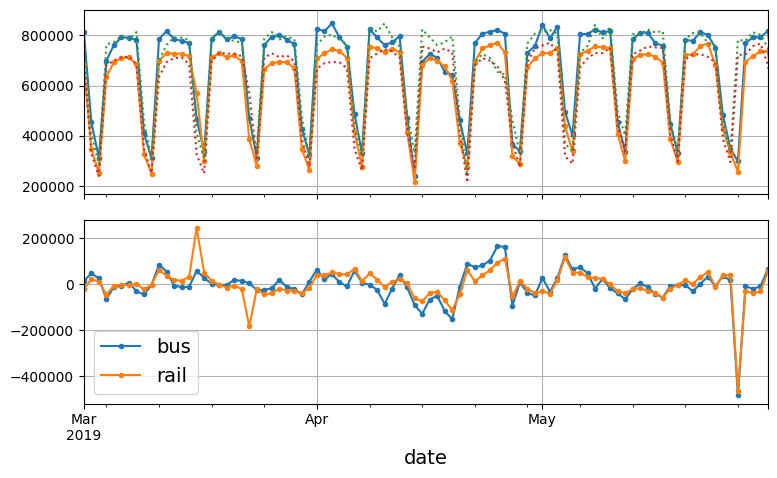

In [10]:
diff_7 = df[["bus", "rail"]].diff(7)["2019-03":"2019-05"]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 5))
df.plot(ax=axs[0], legend=False, marker=".")  # original time series
df.shift(7).plot(ax=axs[0], grid=True, legend=False, linestyle=":")  # lagged
diff_7.plot(ax=axs[1], grid=True, marker=".")  # 7-day difference time series
axs[0].set_ylim([170_000, 900_000])
save_fig("differencing_plot")
plt.show()

In [11]:
list(df.loc["2019-05-25":"2019-05-27"]["day_type"])

['A', 'U', 'U']

Mean absolute error (MAE), also called mean absolute deviation (MAD):

In [12]:
diff_7.abs().mean()

bus     43915.608696
rail    42143.271739
dtype: float64

Mean absolute percentage error (MAPE):

In [13]:
targets = df[["bus", "rail"]]["2019-03":"2019-05"]
(diff_7 / targets).abs().mean()

bus     0.082938
rail    0.089948
dtype: float64

Now let's look at the yearly seasonality and the long-term trends:

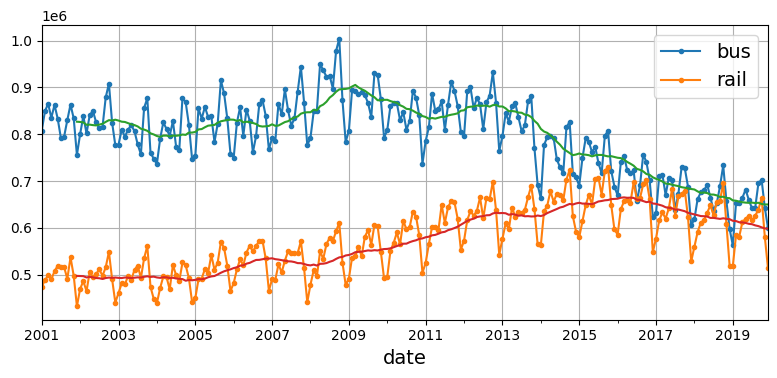

In [14]:
period = slice("2001", "2019")
df_monthly = df.select_dtypes(include='number').resample('M').mean()  # compute the mean for each month
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()

fig, ax = plt.subplots(figsize=(8, 4))
df_monthly[period].plot(ax=ax, marker=".")
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
save_fig("long_term_ridership_plot")
plt.show()

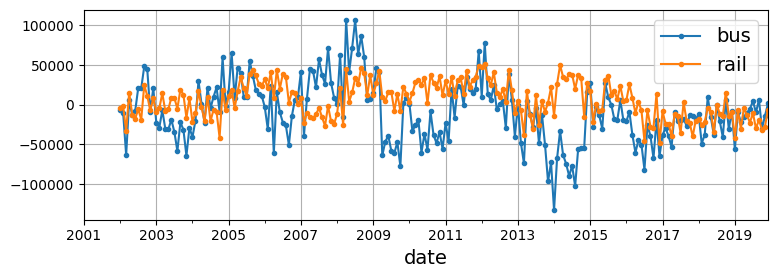

In [15]:
df_monthly.diff(12)[period].plot(grid=True, marker=".", figsize=(8, 3))
save_fig("yearly_diff_plot")
plt.show()

## The ARMA Model Family

_Forecasting using an ARMA model_

$\hat{y}_{(t)} = \Sigma_{i=1}^{p}\alpha_i y_{(t-i)} + \Sigma_{i=1}^{q} \theta_i \epsilon_{(t-i)}$ with $\epsilon_{(t)} = y_{(t)} - \hat{y}_{(t)}$

In this equation:
* $\hat{y}_{(t)}$ is the model's forecast for time step _t_.
* $y_{(t)}$ is the time series' value at time step _t_. 

In [16]:
if "google.colab" in sys.modules:
    %pip install -q -U statsmodels

In [17]:
from statsmodels.tsa.arima.model import ARIMA

origin, today = "2019-01-01", "2019-05-31"
rail_series = df.loc[origin:today]["rail"].asfreq("D")
model = ARIMA(rail_series, 
              order=(1, 0, 0),
              seasonal_order=(0, 1, 1, 7))
model = model.fit()
y_pred = model.forecast()  # returns 427,758.6

In this code example:
* We start by importing the `ARIMA` class, then we take the rail ridership data from the start of 2019 up to "today", and we use `asfreq("D")` to set the time series' frequency to daily: this doesn't change the data at all in this case, since it's already daily, but without this the `ARIMA` class would have to guess the frequency, and it would display a warning.
* Next, we create an `ARIMA` instance, passing it all the data until "today", and we set the model hyperparameters: `order=(1, 0, 0)` means that `p=1, d=0, q=0`, and `seasonal_order=(0, 1, 1, 7)` means that `P=0, D=1, Q=1, and s=7`. Notice that the `statsmodel` API differs a bit from Scikit-Learn's API, since we pass the data to the model at construction time, instead of passing it to the `fit()` method.
* Next, we fit the model, and we use it to make a forecast for "tomorrow", the 1st of June, 2019.

In [18]:
y_pred[0]  # ARIMA forecast

C:\Users\HP\AppData\Local\Temp\ipykernel_23752\3394422362.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred[0]  # ARIMA forecast


427758.62622240453

In [19]:
df["rail"].loc["2019-06-01"]  # target value

379044

In [20]:
df["rail"].loc["2019-05-25"]  # naive forecast (value from one week earlier)

426932

In [21]:
origin, start_date, end_date = "2019-01-01", "2019-03-01", "2019-05-31"
time_period = pd.date_range(start_date, end_date)
rail_series = df.loc[origin:end_date]["rail"].asfreq("D")
y_preds = []
for today in time_period.shift(-1):
    model = ARIMA(rail_series[origin:today],
                    order=(1, 0, 0),
                    seasonal_order=(0, 1, 1, 7))
    model = model.fit()  # note that we retrain the model every day!
    y_pred = model.forecast()[0]
    y_preds.append(y_pred)

y_preds = pd.Series(y_preds, index=time_period)
mae = (y_preds - rail_series[time_period]).abs().mean()  # returns 32,040.7

C:\Users\HP\AppData\Local\Temp\ipykernel_23752\3737485995.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\HP\AppData\Local\Temp\ipykernel_23752\3737485995.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\HP\AppData\Local\Temp\ipykernel_23752\3737485995.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_pred = model.forecast()[0]
C:\Users\HP\AppD

In [22]:
mae

32040.720090488467

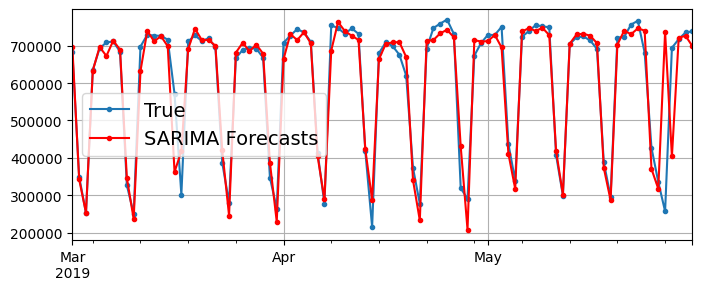

In [23]:
# displays the SARIMA forecasts
fig, ax = plt.subplots(figsize=(8, 3))
rail_series.loc[time_period].plot(label="True", ax=ax, marker=".", grid=True)
ax.plot(y_preds, color="r", marker=".", label="SARIMA Forecasts")
plt.legend()
plt.show()

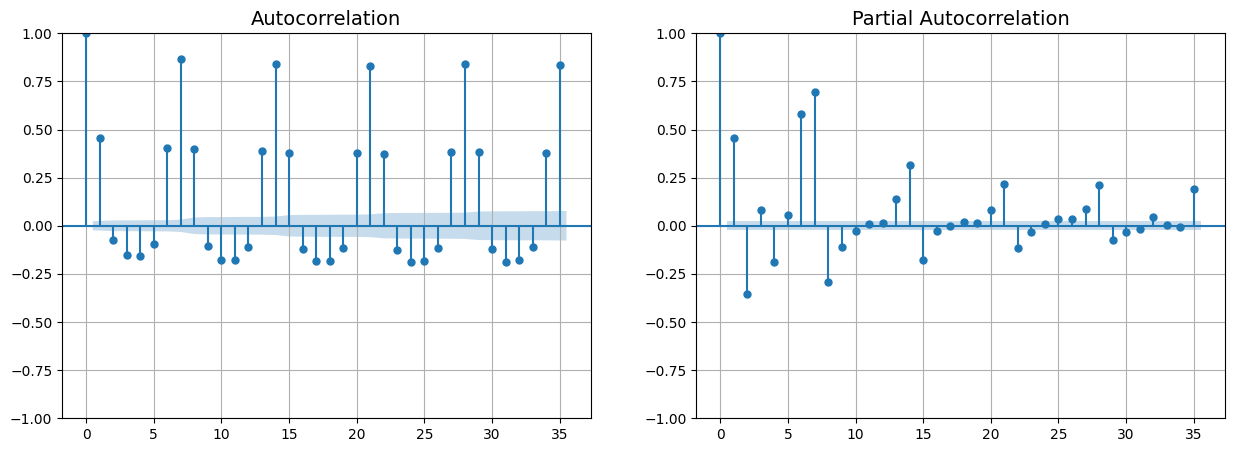

In [24]:
# shows how to plot the Autocorrelation Function (ACF) and the 
#       Partial Autocorrelation Function (PACF)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_acf(df[period]["rail"], ax=axs[0], lags=35)
axs[0].grid()
plot_pacf(df[period]["rail"], ax=axs[1], lags=35, method="ywm")
axs[1].grid()
plt.show()

## Preparing the Data for Machine Learning Models

Keras has a nice utility feature called `tf.keras.utils.timeseries_dataset_from_array()` to help us prepare the training set. It takes a time series as input, and it builds a tf.data.Dataset containing all the windows of the desired length, as well as their corresponding targets.

In [25]:
import tensorflow as tf

my_series = [0, 1, 2, 3, 4, 5]
my_dataset = tf.keras.utils.timeseries_dataset_from_array(
    my_series,
    targets=my_series[3:],  # the targets are 3 steps into the future
    sequence_length=3,
    batch_size=2
)
list(my_dataset)

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5])>)]

In [26]:
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f"{element}", end=" ")
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


In [27]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f"{window_tensor}")

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [28]:
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [29]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int64)>,
  <tf.Tensor: shape=(2,), dtype=int64, numpy=array([3, 4], dtype=int64)>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]], dtype=int64)>,
  <tf.Tensor: shape=(1,), dtype=int64, numpy=array([5], dtype=int64)>)]

Before we continue looking at the data, let's split the time series into three periods, for training, validation and testing. We won't look at the test data for now:

In [30]:
rail_train = df["rail"]["2016-01":"2018-12"] / 1e6
rail_valid = df["rail"]["2019-01":"2019-05"] / 1e6
rail_test = df["rail"]["2019-06":] / 1e6

In [31]:
seq_length = 56
tf.random.set_seed(42)
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

## Forecasting Using a Linear Model

In [32]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])
early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_mae", patience=50, restore_best_weights=True)
opt = tf.keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
history = model.fit(train_ds, validation_data=valid_ds, epochs=500, 
                    callbacks=[early_stopping_cb])

Epoch 1/500
33/33 [==============================] - 3s 22ms/step - loss: 0.0739 - mae: 0.3002 - val_loss: 0.0092 - val_mae: 0.1011
Epoch 2/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0098 - mae: 0.1063 - val_loss: 0.0059 - val_mae: 0.0776
Epoch 3/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0077 - mae: 0.0913 - val_loss: 0.0053 - val_mae: 0.0724
Epoch 4/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0077 - mae: 0.0918 - val_loss: 0.0050 - val_mae: 0.0700
Epoch 5/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0067 - mae: 0.0834 - val_loss: 0.0061 - val_mae: 0.0832
Epoch 6/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0067 - mae: 0.0849 - val_loss: 0.0045 - val_mae: 0.0662
Epoch 7/500
33/33 [==============================] - 0s 5ms/step - loss: 0.0056 - mae: 0.0752 - val_loss: 0.0044 - val_mae: 0.0661
Epoch 8/500
33/33 [==============================] - 0s 4ms/step - loss: 0.0055 - 

In [33]:
valid_loss, valid_mae = model.evaluate(valid_ds)
valid_mae * 1e6

3/3 [==============================] - 0s 4ms/step - loss: 0.0023 - mae: 0.0378


37847.73126244545

## Using a Simple RNN

In [34]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

In [32]:
# utility function we'll reuse several times

def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=["mae"])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs,
                        callbacks=[early_stopping_cb])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 1e6

In [37]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


33/33 [==============================] - 2s 42ms/step - loss: 0.0761 - mae: 0.3205 - val_loss: 0.0740 - val_mae: 0.3422
Epoch 2/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0572 - mae: 0.2855 - val_loss: 0.0460 - val_mae: 0.2471
Epoch 3/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0242 - mae: 0.1673 - val_loss: 0.0162 - val_mae: 0.1524
Epoch 4/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0169 - mae: 0.1615 - val_loss: 0.0166 - val_mae: 0.1372
Epoch 5/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0165 - mae: 0.1595 - val_loss: 0.0161 - val_mae: 0.1381
Epoch 6/500
33/33 [==============================] - 1s 37ms/step - loss: 0.0162 - mae: 0.1569 - val_loss: 0.0157 - val_mae: 0.1391
Epoch 7/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0158 - mae: 0.1564 - val_loss: 0.0154 - val_mae: 0.1402
Epoch 8/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0156 - mae: 

102805.7113289833

The error is very high because of two reasons:
* The model only has a single recurrent neuron, so the only data it can use to make a prediction at each time step is the input value at the current time step and the output value from the previous time step. That's not much to go on! In other words, the RNN's memory is extremely limited: it's just a single number, its previous output. And let's count how many parameters this model has: since there's just one recurrent neuron with only two input values, the whole model only has three parameters (two weights plus a bias term). That's far from enough for this time series. In contrast, our previous model could look at all 56 previous values at once, and it had a total of 56 parameters.
* The time series contains values from 0 to about 1.4, but since the default activation function is tanh, the recurrent layer can only output values between -1 and +1. There's no way it can predict values between 1.0 and 1.4.

In [33]:
tf.random.set_seed(42)
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)  # no activation function by default
])

In [34]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.05)

Epoch 1/500
33/33 [==============================] - 5s 48ms/step - loss: 0.0149 - mae: 0.1220 - val_loss: 0.0040 - val_mae: 0.0753
Epoch 2/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0051 - mae: 0.0716 - val_loss: 0.0028 - val_mae: 0.0525
Epoch 3/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0039 - mae: 0.0560 - val_loss: 0.0019 - val_mae: 0.0372
Epoch 4/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0036 - mae: 0.0534 - val_loss: 0.0024 - val_mae: 0.0469
Epoch 5/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0033 - mae: 0.0511 - val_loss: 0.0021 - val_mae: 0.0387
Epoch 6/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0035 - mae: 0.0533 - val_loss: 0.0019 - val_mae: 0.0343
Epoch 7/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0031 - mae: 0.0496 - val_loss: 0.0020 - val_mae: 0.0313
Epoch 8/500
33/33 [==============================] - 1s 32ms/step - loss: 0.

29509.50339436531

## Deep RNNs

In [ ]:
tf.random.set_seed(42)
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

In [ ]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.01)

Epoch 1/500
33/33 [==============================] - 7s 142ms/step - loss: 0.0203 - mae: 0.1554 - val_loss: 0.0104 - val_mae: 0.0964
Epoch 2/500
33/33 [==============================] - 5s 148ms/step - loss: 0.0057 - mae: 0.0759 - val_loss: 0.0026 - val_mae: 0.0459
Epoch 3/500
33/33 [==============================] - 5s 143ms/step - loss: 0.0045 - mae: 0.0631 - val_loss: 0.0020 - val_mae: 0.0355
Epoch 4/500
33/33 [==============================] - 4s 133ms/step - loss: 0.0046 - mae: 0.0663 - val_loss: 0.0020 - val_mae: 0.0356
Epoch 5/500
33/33 [==============================] - 4s 113ms/step - loss: 0.0041 - mae: 0.0578 - val_loss: 0.0019 - val_mae: 0.0363
Epoch 6/500
33/33 [==============================] - 4s 112ms/step - loss: 0.0037 - mae: 0.0524 - val_loss: 0.0022 - val_mae: 0.0384
Epoch 7/500
33/33 [==============================] - 4s 115ms/step - loss: 0.0038 - mae: 0.0554 - val_loss: 0.0019 - val_mae: 0.0334
Epoch 8/500
33/33 [==============================] - 4s 111ms/step - 

30401.786789298058

## Multivariate time series

In [35]:
df_mulvar = df[["bus", "rail"]] / 1e6  # use both bus & rail series as input
df_mulvar["next_day_type"] = df["day_type"].shift(-1)  # we know tomorrow's type
# df_mulvar = pd.get_dummies(df_mulvar)  # one-hot encode the day type
df_mulvar = pd.get_dummies(df_mulvar, dtype='float32')

In [36]:
mulvar_train = df_mulvar["2016-01":"2018-12"]
mulvar_valid = df_mulvar["2019-01":"2019-05"]
mulvar_test = df_mulvar["2019-06":]

In [37]:
import numpy as np

tf.random.set_seed(42)

train_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),  # use all 5 columns as input
    targets=mulvar_train["rail"][seq_length:],  # forecast only the rail series
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_mulvar_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid["rail"][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [38]:
tf.random.set_seed(42)
mulvar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(1)
])

In [53]:
fit_and_evaluate(mulvar_model, train_mulvar_ds, valid_mulvar_ds,
                 learning_rate=0.05)

Epoch 1/500


33/33 [==============================] - 2s 41ms/step - loss: 0.0593 - mae: 0.2216 - val_loss: 0.0090 - val_mae: 0.1176
Epoch 2/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0036 - mae: 0.0660 - val_loss: 0.0017 - val_mae: 0.0482
Epoch 3/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0023 - mae: 0.0491 - val_loss: 6.9620e-04 - val_mae: 0.0273
Epoch 4/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0016 - mae: 0.0403 - val_loss: 0.0019 - val_mae: 0.0534
Epoch 5/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0015 - mae: 0.0384 - val_loss: 0.0011 - val_mae: 0.0361
Epoch 6/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0015 - mae: 0.0380 - val_loss: 0.0013 - val_mae: 0.0428
Epoch 7/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0016 - mae: 0.0404 - val_loss: 7.8170e-04 - val_mae: 0.0297
Epoch 8/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0014

23017.61507987976

In [39]:
# build and train a multitask RNN that forecasts both bus and rail

tf.random.set_seed(42)

seq_length = 56
train_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=mulvar_train[["bus", "rail"]][seq_length:],  # 2 targets per day
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_multask_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=mulvar_valid[["bus", "rail"]][seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [40]:
tf.random.set_seed(42)
multask_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(2)
])

fit_and_evaluate(multask_model, train_multask_ds, valid_multask_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 39ms/step - loss: 0.0393 - mae: 0.1911 - val_loss: 0.0043 - val_mae: 0.0824
Epoch 2/500
33/33 [==============================] - 1s 34ms/step - loss: 0.0027 - mae: 0.0530 - val_loss: 0.0012 - val_mae: 0.0366
Epoch 3/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0020 - mae: 0.0443 - val_loss: 8.9285e-04 - val_mae: 0.0315
Epoch 4/500
33/33 [==============================] - 1s 38ms/step - loss: 0.0019 - mae: 0.0429 - val_loss: 0.0015 - val_mae: 0.0435
Epoch 5/500
33/33 [==============================] - 1s 35ms/step - loss: 0.0018 - mae: 0.0422 - val_loss: 8.3987e-04 - val_mae: 0.0302
Epoch 6/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0017 - mae: 0.0415 - val_loss: 0.0010 - val_mae: 0.0337
Epoch 7/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0017 - mae: 0.0413 - val_loss: 9.4874e-04 - val_mae: 0.0326
Epoch 8/500
33/33 [==============================] - 1s 34ms/ste

25294.378399848938

In [41]:
bus_naive = mulvar_valid["bus"].shift(7)[seq_length:]
bus_target = mulvar_valid["bus"][seq_length:]
(bus_target - bus_naive).abs().mean() * 1e6

43441.63157894738

In [42]:
Y_preds_valid = multask_model.predict(valid_multask_ds)
for idx, name in enumerate(["bus", "rail"]):
    mae = 1e6 * tf.keras.metrics.mean_absolute_error(
        mulvar_valid[name][seq_length:], Y_preds_valid[:, idx])
    print(name, int(mae))

3/3 [==============================] - 0s 9ms/step
bus 25939
rail 24648


## Forecasting Several Steps Ahead

In [45]:
import numpy as np

X = rail_valid.to_numpy()[np.newaxis, :seq_length, np.newaxis]
for step_ahead in range(14):
    y_pred_one = univar_model.predict(X)
    X = np.concatenate([X, y_pred_one.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 31ms/step


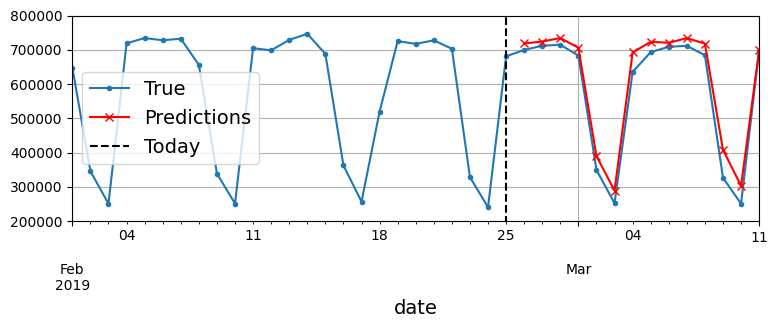

In [46]:
# The forecasts start on 2019-02-26, as it is the 57th day of 2019, and they end
# on 2019-03-11. That's 14 days in total

Y_pred = pd.Series(X[0, -14:, 0],
                   index=pd.date_range("2019-02-26", "2019-03-11"))

fig, ax = plt.subplots(figsize=(8, 3.5))
(rail_valid * 1e6)["2019-02-01":"2019-03-11"].plot(
    label="True", marker=".", ax=ax)
(Y_pred * 1e6).plot(
    label="Predictions", grid=True, marker="x", color="r", ax=ax)
ax.vlines("2019-02-25", 0, 1e6, color="k", linestyle="--", label="Today")
ax.set_ylim([200_000, 800_000])
plt.legend(loc="center left")
save_fig("forecast_ahead_plot")
plt.show()

Now let's create an RNN that predicts all 14 next values at once:

In [43]:
tf.random.set_seed(42)

def split_inputs_and_targets(mulvar_series, ahead=14, target_col=1):
    return mulvar_series[:, :-ahead], mulvar_series[:, -ahead:, target_col]

ahead_train_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_train.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32,
    shuffle=True,
    seed=42
).map(split_inputs_and_targets)
ahead_valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    mulvar_valid.to_numpy(),
    targets=None,
    sequence_length=seq_length + 14,
    batch_size=32
).map(split_inputs_and_targets)

In [49]:
tf.random.set_seed(42)

ahead_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [50]:
fit_and_evaluate(ahead_model, ahead_train_ds, ahead_valid_ds,
                 learning_rate=0.02)

Epoch 1/500
33/33 [==============================] - 2s 41ms/step - loss: 0.0927 - mae: 0.3205 - val_loss: 0.0264 - val_mae: 0.1814
Epoch 2/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0193 - mae: 0.1573 - val_loss: 0.0150 - val_mae: 0.1322
Epoch 3/500
33/33 [==============================] - 1s 30ms/step - loss: 0.0141 - mae: 0.1337 - val_loss: 0.0118 - val_mae: 0.1171
Epoch 4/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0117 - mae: 0.1211 - val_loss: 0.0095 - val_mae: 0.1056
Epoch 5/500
33/33 [==============================] - 1s 33ms/step - loss: 0.0100 - mae: 0.1106 - val_loss: 0.0081 - val_mae: 0.0960
Epoch 6/500
33/33 [==============================] - 1s 32ms/step - loss: 0.0087 - mae: 0.1012 - val_loss: 0.0065 - val_mae: 0.0864
Epoch 7/500
33/33 [==============================] - 1s 31ms/step - loss: 0.0077 - mae: 0.0936 - val_loss: 0.0056 - val_mae: 0.0797
Epoch 8/500
33/33 [==============================] - 1s 31ms/step - loss: 0.

33990.62901735306

In [55]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]  # shape [1, 56, 5]
Y_pred = ahead_model.predict(X)  # shape [1, 14]

1/1 [==============================] - 0s 149ms/step


Now let's create an RNN that predicts the next 14 steps at each time step. That is, instead of just forecasting time steps 56 to 69 based on time steps 0 to 55, it will forecast time steps 1 to 14 at time step 0, then time steps 2 to 15 at time step 1, and so on, and finally it will forecast time steps 56 to 69 at the last time step. Notice that the model is causal: when it makes predicitons at any time step, it can only see past time steps.

To prepare the dataset, we can use `to_windows()` twice, to get sequences of conssecutive windows, like this:

In [36]:
my_series = tf.data.Dataset.range(7)
dataset = to_windows(to_windows(my_series, 3), 4)
list(dataset)

[<tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5]], dtype=int64)>,
 <tf.Tensor: shape=(4, 3), dtype=int64, numpy=
 array([[1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6]], dtype=int64)>]

Then we can split these elements into the desired inputs and targets:

In [37]:
dataset = dataset.map(lambda S: (S[:, 0], S[:, 1:]))
list(dataset)

[(<tf.Tensor: shape=(4,), dtype=int64, numpy=array([0, 1, 2, 3], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[1, 2],
         [2, 3],
         [3, 4],
         [4, 5]], dtype=int64)>),
 (<tf.Tensor: shape=(4,), dtype=int64, numpy=array([1, 2, 3, 4], dtype=int64)>,
  <tf.Tensor: shape=(4, 2), dtype=int64, numpy=
  array([[2, 3],
         [3, 4],
         [4, 5],
         [5, 6]], dtype=int64)>)]

Let's wrap this idea into a utility function. It will also take care of shuffling (optional) and batching:

In [44]:
def to_seq2seq_dataset(series, seq_length=56, ahead=14, target_col=1,
                       batch_size=32, shuffle=False, seed=None):
    ds = to_windows(tf.data.Dataset.from_tensor_slices(series), ahead + 1)
    ds = to_windows(ds, seq_length).map(lambda S: (S[:, 0], S[:, 1:, 1]))
    if shuffle:
        ds = ds.shuffle(8 * batch_size, seed=seed)
    return ds.batch(batch_size)

In [45]:
seq2seq_train = to_seq2seq_dataset(mulvar_train, shuffle=True, seed=42)
seq2seq_valid = to_seq2seq_dataset(mulvar_valid)

In [46]:
tf.random.set_seed(42)
seq2seq_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
    # equivalent: tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(14))
    # also equivalent: tf.keras.layers.Conv1D(14, kernel_size=1)
])

In [61]:
fit_and_evaluate(seq2seq_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1)

Epoch 1/500
33/33 [==============================] - 3s 59ms/step - loss: 0.0853 - mae: 0.2895 - val_loss: 0.0150 - val_mae: 0.1299
Epoch 2/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0101 - mae: 0.1079 - val_loss: 0.0080 - val_mae: 0.0903
Epoch 3/500
33/33 [==============================] - 1s 43ms/step - loss: 0.0072 - mae: 0.0875 - val_loss: 0.0069 - val_mae: 0.0822
Epoch 4/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0061 - mae: 0.0784 - val_loss: 0.0060 - val_mae: 0.0748
Epoch 5/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0054 - mae: 0.0719 - val_loss: 0.0052 - val_mae: 0.0673
Epoch 6/500
33/33 [==============================] - 1s 39ms/step - loss: 0.0051 - mae: 0.0684 - val_loss: 0.0053 - val_mae: 0.0688
Epoch 7/500
33/33 [==============================] - 1s 40ms/step - loss: 0.0048 - mae: 0.0655 - val_loss: 0.0049 - val_mae: 0.0642
Epoch 8/500
33/33 [==============================] - 1s 41ms/step - loss: 0.

46410.53080558777

In [41]:
X = mulvar_valid.to_numpy()[np.newaxis, :seq_length]
y_pred_14 = seq2seq_model.predict(X)[0, -1]  # only the last time step's output

1/1 [==============================] - 3s 3s/step


In [42]:
Y_pred_valid = seq2seq_model.predict(seq2seq_valid)
for ahead in range(14):
    preds = pd.Series(Y_pred_valid[:-1, -1, ahead],
                      index=mulvar_valid.index[56 + ahead : -14 + ahead])
    mae = (preds - mulvar_valid["rail"]).abs().mean() * 1e6
    print(f"MAE for +{ahead + 1}: {mae:,.0f}")

3/3 [==============================] - 0s 66ms/step
MAE for +1: 597,226
MAE for +2: 713,158
MAE for +3: 730,214
MAE for +4: 270,730
MAE for +5: 783,745
MAE for +6: 639,254
MAE for +7: 718,444
MAE for +8: 141,771
MAE for +9: 874,152
MAE for +10: 331,357
MAE for +11: 559,067
MAE for +12: 247,593
MAE for +13: 490,954
MAE for +14: 958,433


# Deep RNNs wth Layer Norm

In [47]:
class LNSimpleRNNCell(tf.keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(units,
                                                             activation=None)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

Let's walk thorugh this code:
* Our `LNSimpleRNNCell` class inherits from the `tf.keras.layers.Layer` class, just like any custom layer.
* The constructor takes the number of units and the desired activation function and sets the `state_size` and `output_size` attributes, then creates a `SimpleRNNCell` with no activation function (because we want to perform layer normalization after the linear operation but before the activation function). Then the constructor creates the `LayerNormalization` layer, and finally it fetches the desired activation function.
* The `call()` method starts by applying the `simpleRNNCell`, which computes a linear combination of the current inputs and the previous hidden states, and it returns the result twice (indeed, in a `SimpleRNNCell`, the outputs are just equal to the hidden states; in other words, `new_states[0]` is equal to the outputs, so we can safely ignore `new_states` in the rest of the `call()` method). Next, the `call()` method applies layer normalization, followed by the activation function. Finally, it returns the output twice: once as the outputs, and the once as the new hidden states. To use this custom cell, all we need to do is to create a `tf.keras.layers.RNN` layer, passing it a cell instance.

In [44]:
tf.random.set_seed(42)
custom_ln_model = tf.keras.Sequential([
    tf.keras.layers.RNN(LNSimpleRNNCell(32), return_sequences=True,
                        input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [45]:
fit_and_evaluate(custom_ln_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 8s 112ms/step - loss: 0.0707 - mae: 0.2693 - val_loss: 0.0194 - val_mae: 0.1474
Epoch 2/5
33/33 [==============================] - 3s 89ms/step - loss: 0.0152 - mae: 0.1474 - val_loss: 0.0158 - val_mae: 0.1310
Epoch 3/5
33/33 [==============================] - 3s 94ms/step - loss: 0.0129 - mae: 0.1356 - val_loss: 0.0146 - val_mae: 0.1212
Epoch 4/5
33/33 [==============================] - 3s 97ms/step - loss: 0.0116 - mae: 0.1257 - val_loss: 0.0133 - val_mae: 0.1146
Epoch 5/5
3/3 [==============================] - 0s 28ms/step - loss: 0.0115 - mae: 0.1087


108740.08387327194

# Creating a Custom RNN Class

In [48]:
class MyRNN(tf.keras.layers.Layer):
    def __init__(self, cell, return_sequences=False, **kwargs):
        super().__init__(**kwargs)
        self.cell = cell
        self.return_sequences = return_sequences
    
    def get_initial_state(self, inputs):
        try:
            return self.cell.get_initial_state(inputs)
        except AttributeError:
            # fallback to zeros if self.cell has no get_initial_state() method
            batch_size = tf.shape(inputs)[0]
            return [tf.zeros([batch_size, self.cell.state_size],
                            dtype=inputs.dtype)]
    
    @tf.function
    def call(self, inputs):
        states = self.get_initial_state(inputs)
        shape = tf.shape(inputs)
        batch_size = shape[0]
        n_steps = shape[1]
        sequences = tf.TensorArray(
            inputs.dtype, size=(n_steps if self.return_sequences else 0))
        outputs = tf.zeros(shape=[batch_size, self.cell.output_size],
                           dtype=inputs.dtype)
        for step in tf.range(n_steps):
            outputs, states = self.cell(inputs[:, step], states)
            if self.return_sequences:
                sequences = sequences.write(step, outputs)
        
        if self.return_sequences:
            # stack the outputs into an array of shape
            # [time steps, batch size, dims], then transpose it to shape
            # [batch size, time steps, dims]
            return tf.transpose(sequences.stack(), [1, 0, 2])
        else:
            return outputs

Note that `@tf.function` requires the `outputs` variable to be created before the `for` loop, which is why we initialize its value to a zero tensor, even though we don't use that value at all. Once the function is converted to a graph, this unused value will be pruned from the graph, so it doesn't impact performance. Similarly, `@tf.function` requiress the `sequences` variable to be created before the `if` statement where it is used, even if `self.return_sequences` is `False`, so we create a `TensorArray` of size 0 in this case.

In [47]:
tf.random.set_seed(42)

custom_model = tf.keras.Sequential([
    MyRNN(LNSimpleRNNCell(32), return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [48]:
fit_and_evaluate(custom_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 4s 105ms/step - loss: 0.0947 - mae: 0.3098 - val_loss: 0.0217 - val_mae: 0.1574
Epoch 2/5
33/33 [==============================] - 3s 95ms/step - loss: 0.0125 - mae: 0.1251 - val_loss: 0.0116 - val_mae: 0.1087
Epoch 3/5
33/33 [==============================] - 3s 102ms/step - loss: 0.0090 - mae: 0.1029 - val_loss: 0.0092 - val_mae: 0.0969
Epoch 4/5
33/33 [==============================] - 4s 106ms/step - loss: 0.0077 - mae: 0.0926 - val_loss: 0.0088 - val_mae: 0.0944
Epoch 5/5
3/3 [==============================] - 0s 32ms/step - loss: 0.0080 - mae: 0.0897


89736.19341850281

# LSTMs

The _long short-term memory_ (LSTM) cell was proposed in 1997 by Sepp Hochreiter and Jurgen Schmidhuber and gradually improved over the years by several researchers, such as ALex Graves, Hasim Sak, and Wojciech Zaremba.

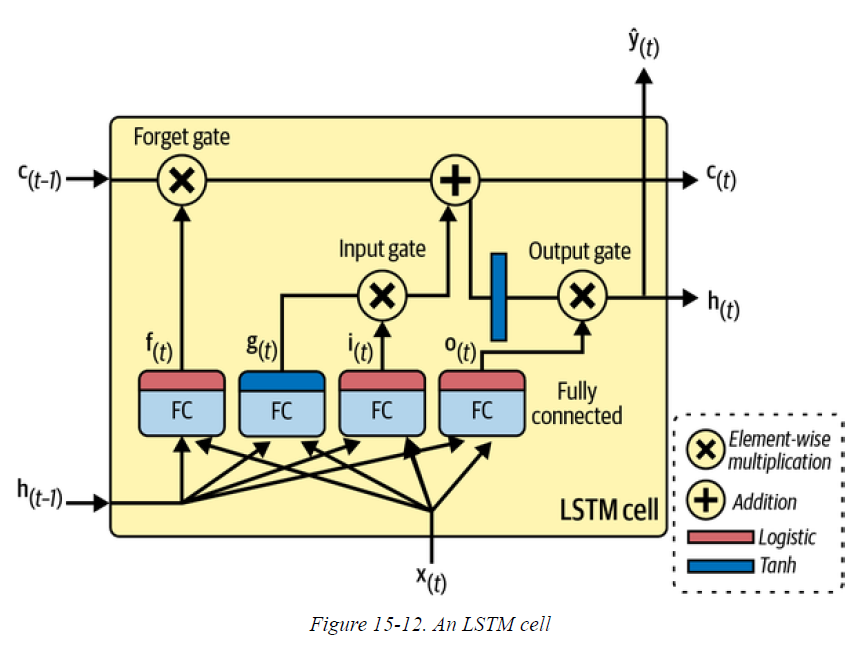

The key idea is that the network can learn what to do in the long-term state, what to throw away, and what to read from it. As the long-term state $\mathbf{c}_{(t-1)}$ traverses the network from left to right, you can see that it first goes through a _forget gate_, dropping some memories, and then it adds some new memories via the addition operation (which adds the memories that were selected by an _input gate_). The result $\mathbf{c}_t$ is sent straight out, without any further transformation. So, at each time step, some memories are dropped and some memories are added. Moreover, after the addition operation, the long-term state is copied and passed through the tanh function, and then the result is filtered 

In [49]:
tf.random.set_seed(42)
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [50]:
fit_and_evaluate(lstm_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 5s 42ms/step - loss: 0.0563 - mae: 0.2541 - val_loss: 0.0178 - val_mae: 0.1574
Epoch 2/5
33/33 [==============================] - 1s 16ms/step - loss: 0.0165 - mae: 0.1563 - val_loss: 0.0171 - val_mae: 0.1421
Epoch 3/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0152 - mae: 0.1489 - val_loss: 0.0162 - val_mae: 0.1397
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0145 - mae: 0.1452 - val_loss: 0.0155 - val_mae: 0.1363
Epoch 5/5
3/3 [==============================] - 0s 16ms/step - loss: 0.0149 - mae: 0.1330


133015.27500152588

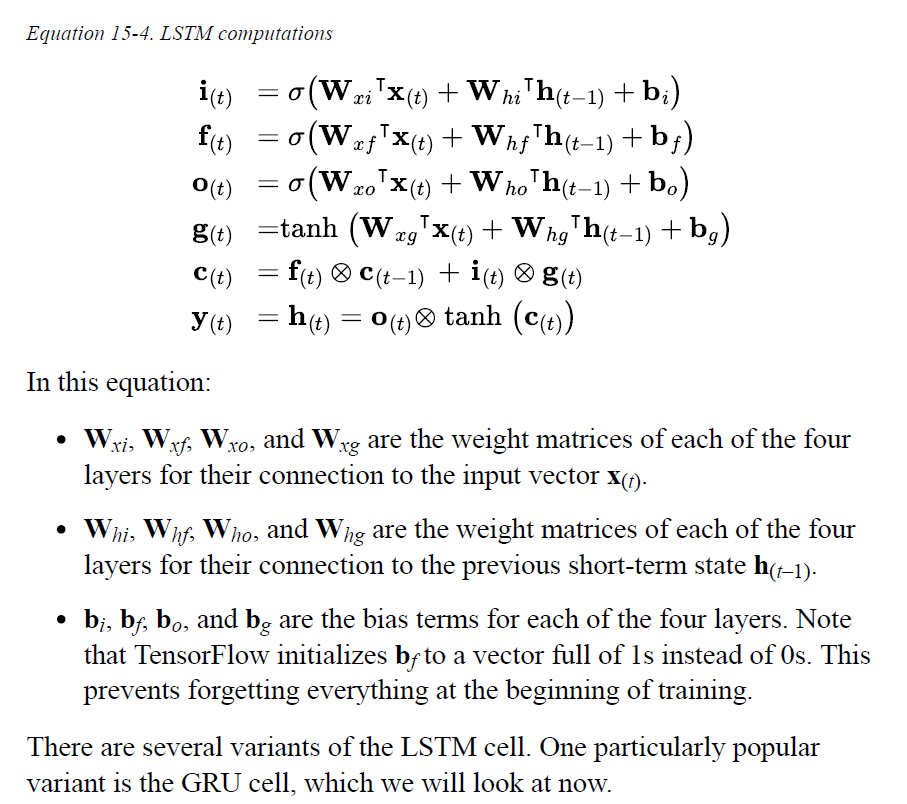

# GRUs

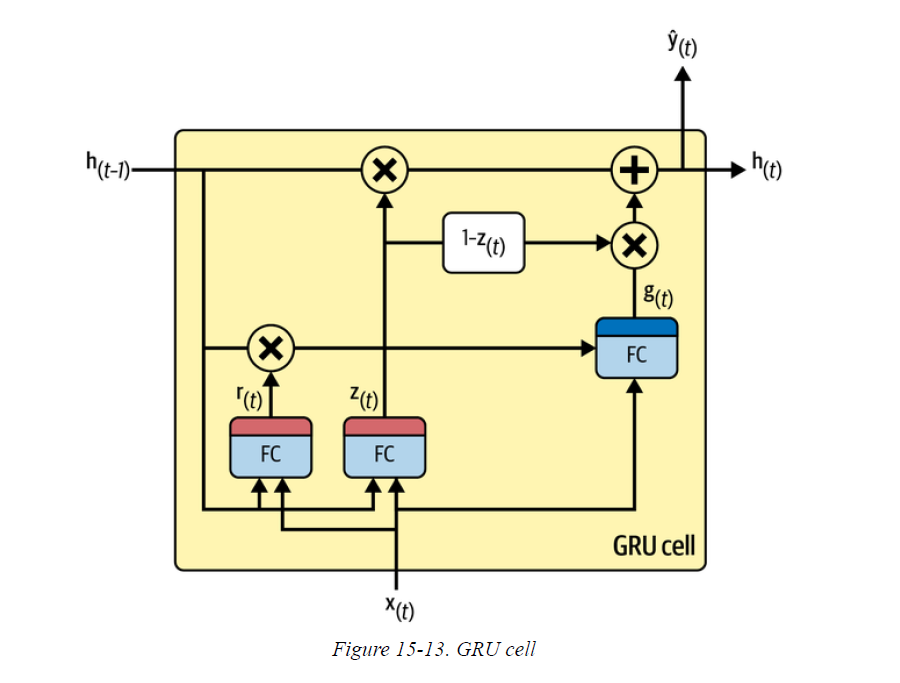

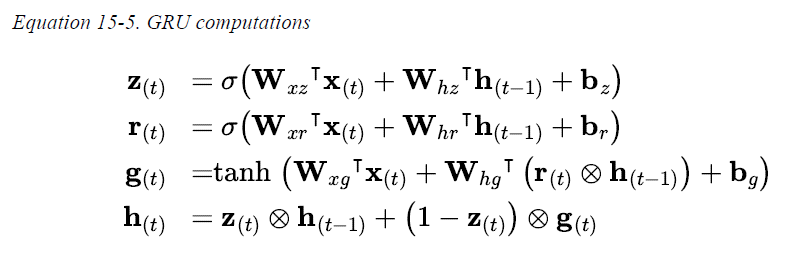

In [49]:
tf.random.set_seed(42)
gru_model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, return_sequences=True, input_shape=[None, 5]),
    tf.keras.layers.Dense(14)
])

In [52]:
fit_and_evaluate(gru_model, seq2seq_train, seq2seq_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
33/33 [==============================] - 2s 27ms/step - loss: 0.0616 - mae: 0.2666 - val_loss: 0.0176 - val_mae: 0.1579
Epoch 2/5
33/33 [==============================] - 0s 13ms/step - loss: 0.0144 - mae: 0.1396 - val_loss: 0.0137 - val_mae: 0.1281
Epoch 3/5
33/33 [==============================] - 0s 11ms/step - loss: 0.0120 - mae: 0.1265 - val_loss: 0.0128 - val_mae: 0.1217
Epoch 4/5
33/33 [==============================] - 0s 12ms/step - loss: 0.0111 - mae: 0.1211 - val_loss: 0.0121 - val_mae: 0.1180
Epoch 5/5
3/3 [==============================] - 0s 20ms/step - loss: 0.0114 - mae: 0.1153


115322.76123762131

## Using One-Dimensional Convolutional Layers to Process Sequences

```
  |-----0-----|      |-----3----|      |--... |-------52------|
         |-----1----|      |-----4----|   ... |       |-------53------|
               |-----2----|     |------5--...-51------|       |-------54------|
X:  0  1  2  3  4  5  6  7  8  9 10 11 12 ...  104 105 106 107 108 109 110 111
Y:      from 4     6     8    10    12    ...      106     108     110     112
         to 17    19    21    23    25    ...      119     121     123     125
```

In [50]:
tf.random.set_seed(42)
conv_rnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=4, strides=2,
                           activation="relu", input_shape=[None, 5]),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.Dense(14)
])

longer_train = to_seq2seq_dataset(mulvar_train, seq_length=112,
                                    shuffle=True, seed=42)
longer_valid = to_seq2seq_dataset(mulvar_valid, seq_length=112)
downsampled_train = longer_train.map(lambda X, Y: (X, Y[:, 3::2]))
downsampled_valid = longer_valid.map(lambda X, Y: (X, Y[:, 3::2]))

In [55]:
fit_and_evaluate(conv_rnn_model, downsampled_train, downsampled_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 13s 87ms/step - loss: 0.0597 - mae: 0.2648 - val_loss: 0.0197 - val_mae: 0.1561
Epoch 2/5
31/31 [==============================] - 1s 30ms/step - loss: 0.0150 - mae: 0.1449 - val_loss: 0.0151 - val_mae: 0.1317
Epoch 3/5
31/31 [==============================] - 1s 27ms/step - loss: 0.0123 - mae: 0.1319 - val_loss: 0.0134 - val_mae: 0.1216
Epoch 4/5
31/31 [==============================] - 1s 25ms/step - loss: 0.0108 - mae: 0.1201 - val_loss: 0.0119 - val_mae: 0.1141
Epoch 5/5
1/1 [==============================] - 0s 207ms/step - loss: 0.0107 - mae: 0.1085


108488.21699619293

## Wavenet

```
 ⋮
C2  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\...
   \  /  \  /  \  /  \  /  \  /  \  /  \     
     /    \      /    \      /    \          
C1  /\ /\ /\ /\ /\ /\ /\ /\ /\ /\ /\  /\ /...\
X: 0  1  2  3  4  5  6  7  8  9  10 11 12 ... 111
Y: 1  2  3  4  5  6  7  8  9  10 11 12 13 ... 112
 /14 15 16 17 18 19 20 21 22  23 24 25 26 ... 125
```

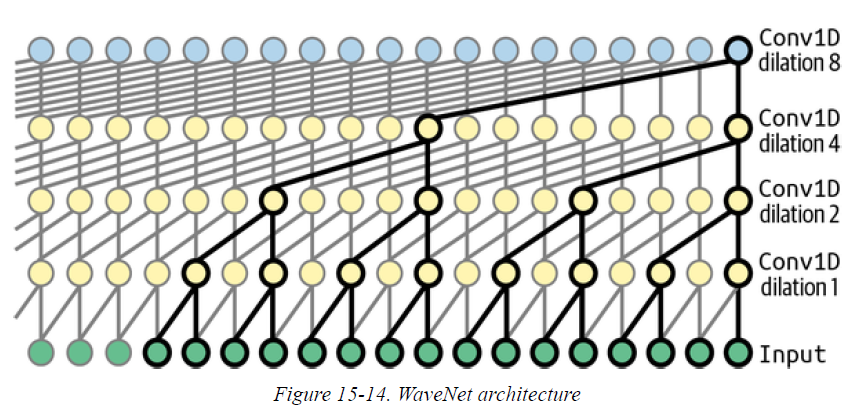

In [51]:
tf.random.set_seed(42)
wavenet_model = tf.keras.Sequential()
wavenet_model.add(tf.keras.layers.InputLayer(input_shape=[None, 5]))
for rate in (1, 2, 4, 8) * 2:
    wavenet_model.add(tf.keras.layers.Conv1D(
        filters=32, kernel_size=2, padding="causal", activation="relu",
        dilation_rate=rate))
wavenet_model.add(tf.keras.layers.Conv1D(filters=14, kernel_size=1))

In [57]:
fit_and_evaluate(wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 6s 70ms/step - loss: 0.0774 - mae: 0.3114 - val_loss: 0.0230 - val_mae: 0.1616
Epoch 2/5
31/31 [==============================] - 1s 26ms/step - loss: 0.0166 - mae: 0.1561 - val_loss: 0.0181 - val_mae: 0.1518
Epoch 3/5
31/31 [==============================] - 1s 26ms/step - loss: 0.0154 - mae: 0.1529 - val_loss: 0.0174 - val_mae: 0.1459
Epoch 4/5
31/31 [==============================] - 1s 29ms/step - loss: 0.0143 - mae: 0.1457 - val_loss: 0.0159 - val_mae: 0.1362
Epoch 5/5
1/1 [==============================] - 0s 155ms/step - loss: 0.0138 - mae: 0.1239


123916.26834869385

# Wavenet Implementation

Here is the original WaveNet defined in the paper: it uses Gated Activation Unit instead of ReLU and parametrized skip connections, plus it pads with zeros on the left to avoid getting shorter and shorter sequences:

In [52]:
class GatedActivationUnit(tf.keras.layers.Layer):
    def __init__(self, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
    
    def call(self, inputs):
        n_filters = inputs.shape[-1] // 2
        linear_output = self.activation(inputs[..., :n_filters])
        gate = tf.keras.activations.sigmoid(inputs[..., n_filters:])
        return self.activation(linear_output) * gate

In [53]:
def wavenet_residual_block(inputs, n_filters, dilation_rate):
    z = tf.keras.layers.Conv1D(2 * n_filters, kernel_size=2, padding="causal",
                                dilation_rate=dilation_rate)(inputs)
    z = GatedActivationUnit()(z)
    z = tf.keras.layers.Conv1D(n_filters, kernel_size=1)(z)
    return tf.keras.layers.Add()([z, inputs]), z

In [55]:
tf.random.set_seed(42)

n_layers_per_block = 3  # 10 in the paper
n_blocks = 1  # 3 in the paper
n_filters = 32  # 128 in the paper
n_outputs = 14  # 256 in the paper

inputs = tf.keras.layers.Input(shape=[None, 5])
z = tf.keras.layers.Conv1D(n_filters, kernel_size=2, padding="causal")(inputs)
skip_to_last = []
for dilation_rate in [2**i for i in range(n_layers_per_block)] * n_blocks:
    z, skip = wavenet_residual_block(z, n_filters, dilation_rate)
    skip_to_last.append(skip)

z = tf.keras.activations.relu(tf.keras.layers.Add()(skip_to_last))
z = tf.keras.layers.Conv1D(n_filters, kernel_size=1, activation="relu")(z)
Y_preds = tf.keras.layers.Conv1D(n_outputs, kernel_size=1)(z)

full_wavenet_model = tf.keras.Model(inputs=[inputs], outputs=[Y_preds])

In [56]:
fit_and_evaluate(full_wavenet_model, longer_train, longer_valid,
                 learning_rate=0.1, epochs=5)

Epoch 1/5
31/31 [==============================] - 10s 64ms/step - loss: 0.0699 - mae: 0.2895 - val_loss: 0.0209 - val_mae: 0.1630
Epoch 2/5
31/31 [==============================] - 0s 11ms/step - loss: 0.0153 - mae: 0.1470 - val_loss: 0.0160 - val_mae: 0.1374
Epoch 3/5
31/31 [==============================] - 1s 14ms/step - loss: 0.0127 - mae: 0.1341 - val_loss: 0.0143 - val_mae: 0.1254
Epoch 4/5
31/31 [==============================] - 0s 11ms/step - loss: 0.0108 - mae: 0.1207 - val_loss: 0.0124 - val_mae: 0.1148
Epoch 5/5
1/1 [==============================] - 0s 65ms/step - loss: 0.0103 - mae: 0.1044


104430.74256181717

# Exercise solutions

## 1. to 8.

1. Here are a few RNN applications:
    * For a sequence-to-sequence RNN: predicting the weather (or any other time series), machine translation (using an Encoder-Decoder architecture), video captioning, speech to text, music generation (or other sequence generation), identifying the chords of a string.
    * For a sequence-to-vector RNN: classifying music samples by music genre, analyzing the sentiment of a book review, predicting what word an aphasic patient is thinking of based on readings from brain implants, predicting the probability that a user will want to watch a movie based on their watch history.
    * For a vector-to-sequence RNN: image captioning, creating a music playlist based on an embedding of the curret artist, generating a melody based on a set of parameters, locating pedestrians in a picture (e.g., a video frame from a self-driving car's camera)
2. An RNN layer must have three-dimensional inputs: the first dimension is the batch dimension (its size is the batch size), the second dimension represents the time (its size is the number of time steps), and the third dimension holds the inputs at each time step (its size is the number of input features per time step). For example, if you want to process a batch containing 5 time series of 10 time steps each, with 2 values per time step (e.g., the temperature and the wind speed), the shape will be [5, 10, 2]. The outputs are also three-dimensional, with the same first two dimensions, but the last dimension is equal to the number of neurons. For example, if an RNN layer with 32 neurons processes the batch we just discussed, the output will have a shape of [5, 10, 32].
3. To build a deep sequence-to-sequence RNN using Keras, you must build set `return_sequences=True` for all RNN layers. To build a sequence-to-vector RNN layer, you must set `return_sequences=True` for all RNN layers except for the top RNN layer, which must have `return_sequences=False` (or do not set this argument at all, since `False` is the default).
4. If you have a daily univariate time series, and you want to forecast the next seven days, the simplest RNN architecture you can use is a stack of RNN layers (all with `return_sequences=True` except for the top RNN layer), using seven neurons in the output RNN layer. You can then train this model using random windows from the time series (e.g., sequences of 30 consecutive days as the inputs, and a vector containing the values of the next 7 days as the target). This is a sequence-to-vector RNN. Alternatively, you could set `return_sequences=True` for all RNN layers to create a sequence-to-sequence RNN. You can train this model using random windows from the time series, with sequences of the same length as the inputs as the targets. Each target sequence should have seven values per time step (e.g., for time step _t_, the target should be a vector containing the values at time steps _t + 1_ to _t + 7_).
5. The two main difficulties when training RNNs are unstable gradients (exploding or vanishing) and a very limited short-term memory. These problems both get worse when dealing with long sequences. To alleviate the unstable gradients problem, you can use a smaller learning rate, use a saturating activation function such as the hyperbolic tangent (which is the default), and possible use gradient clipping, Layer Normalization, or dropout at each time step. To tackle the limited short-term memory problem, you can use `LSTM` or `GRU` layers (this also helps with the unstable gradients problem).
6. An LSTM cell's architecture looks complicated, but it's actually not too hard if you understand the underlying logic. The cell has a short-term state vector and a long-term state vector. At each time step, the inputs and the previous short-term state are fed to a simple RNN cell and three gates: the forget gate decides which part of the output of the simple RNN cell should be added to the long-term state, and the output gate decides which part of the long-term state should be output at this time step (after going through the tanh activation function). The new short-term state is equal to the output of the cell.
7. An RNN layer is fundamentally sequential: in order to compute the outputs at time step _t_, it has to first compute the outputs at all earlier time steps. This makes it impossible to parallelize. On the other hand, a 1D convolutional layer lends itself well to parallelization since it does not hold a state between time steps. In other words, it has no memory: the output at any time step can be computed based only on a small window of values from the inputs without having to know all the past values. Moreover, since a 1D convoluitonal layer is not recurrent, it suffers less from unstable gradients. One or more 1D convolutional layers can be useful in an RNN to efficiently preprocess the inputs, for example to reduce their temporal resolution (downsampling) and thereby help the RNN layers detect long-term patterns. In fact, it is possible to use any convolutional layers, for example by building a WaveNet architecture.
8. To classify videos based on their visual content, one possible architecture could be to take (say) one frame per second, then run every frame through the same convolutional neural network (e.g., a pretrained Xception model, possibly frozen if your dataset is not large), feed the sequence of outputs from the CNN to a sequence-to-vector RNN, and finally run its output through a softmax layer, giving you all the class probabilities. For training you would use cross entropy as the cost funciton. If you wanted to use the audio for classification as well, you could use a stack of strided 1D convolutional layers to reduce the temporal resolution from thousands of audio frames per second to just one per second (to match the number of images per second), and concatenate the output sequence to the inputs of the sequence-to-vector RNN (along the last dimension).

## 9. Tackling the SketchRNN Dataset

_Exercise: Train a classification model for the SketchRNN dataset, available in TensorFLow Datasets._

In [6]:
tf_download_root = "http://download.tensorflow.org/data/"
filename = "quickdraw_tutorial_dataset_v1.tar.gz"
filepath = tf.keras.utils.get_file(filename,
                                    tf_download_root + filename,
                                    cache_dir=".",
                                    extract=True)

In [7]:
quickdraw_dir = Path(filepath).parent
train_files = sorted(
    [str(path) for path in quickdraw_dir.glob("training.tfrecord-*")]
)
eval_files = sorted(
    [str(path) for path in quickdraw_dir.glob("eval.tfrecord-*")]
)

In [8]:
train_files

['datasets\\training.tfrecord-00000-of-00010',
 'datasets\\training.tfrecord-00001-of-00010',
 'datasets\\training.tfrecord-00002-of-00010',
 'datasets\\training.tfrecord-00003-of-00010',
 'datasets\\training.tfrecord-00004-of-00010',
 'datasets\\training.tfrecord-00005-of-00010',
 'datasets\\training.tfrecord-00006-of-00010',
 'datasets\\training.tfrecord-00007-of-00010',
 'datasets\\training.tfrecord-00008-of-00010',
 'datasets\\training.tfrecord-00009-of-00010']

In [9]:
eval_files

['datasets\\eval.tfrecord-00000-of-00010',
 'datasets\\eval.tfrecord-00001-of-00010',
 'datasets\\eval.tfrecord-00002-of-00010',
 'datasets\\eval.tfrecord-00003-of-00010',
 'datasets\\eval.tfrecord-00004-of-00010',
 'datasets\\eval.tfrecord-00005-of-00010',
 'datasets\\eval.tfrecord-00006-of-00010',
 'datasets\\eval.tfrecord-00007-of-00010',
 'datasets\\eval.tfrecord-00008-of-00010',
 'datasets\\eval.tfrecord-00009-of-00010']

In [10]:
with open(quickdraw_dir / "eval.tfrecord.classes") as test_classes_file:
    test_classes = test_classes_file.readlines()

with open(quickdraw_dir / "training.tfrecord.classes") as train_classes_file:
    train_classes = train_classes_file.readlines()

In [11]:
assert train_classes == test_classes
class_names = [name.strip().lower() for name in train_classes]

In [12]:
sorted(class_names)

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball',
 'baseball bat',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

In [13]:
def parse(data_batch):
    feature_descriptions = {
        "ink": tf.io.VarLenFeature(dtype=tf.float32),
        "shape": tf.io.FixedLenFeature([2], dtype=tf.int64),
        "class_index": tf.io.FixedLenFeature([1], dtype=tf.int64)
    }
    examples = tf.io.parse_example(data_batch, feature_descriptions)
    flat_sketches = tf.sparse.to_dense(examples["ink"])
    sketches = tf.reshape(flat_sketches, shape=[tf.size(data_batch), -1, 3])
    lengths = examples["shape"][:, 0]
    labels = examples["class_index"][:, 0]
    return sketches, lengths, labels

In [14]:
def quickdraw_dataset(filepaths, batch_size=32, shuffle_buffer_size=None,
                      n_parse_threads=5, n_read_threads=5, cache=False):
    dataset = tf.data.TFRecordDataset(filepaths,
                                    num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(parse, num_parallel_calls=n_parse_threads)
    return dataset.prefetch(1)

In [15]:
train_set = quickdraw_dataset(train_files, shuffle_buffer_size=10_000)
valid_set = quickdraw_dataset(eval_files[:5])
test_set = quickdraw_dataset(eval_files[5:])

In [16]:
for sketches, lengths, labels in train_set.take(1):
    print("sketches =", sketches)
    print("lenghts =", lengths)
    print("labels =", labels)

sketches = tf.Tensor(
[[[ 0.         -0.28936172  0.        ]
  [ 0.03529415 -0.39148936  0.        ]
  [-0.03137258 -0.31914893  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.2862745   0.00704225  0.        ]
  [-0.18431371 -0.07042254  0.        ]
  [-0.14509806 -0.00704225  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 [[-0.12156864 -0.03141361  0.        ]
  [-0.06666667  0.03141361  0.        ]
  [-0.0509804   0.21465969  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]]

 ...

 [[ 0.24313726  0.          0.        ]
  [ 0.16470589  0.10843372  0.        ]
  [ 0.12156865 -0.06024098  0.        ]
  ...
  [ 0.          0.          0.        ]
  [ 0.          0.          0.        ]
  [ 0.          0.    

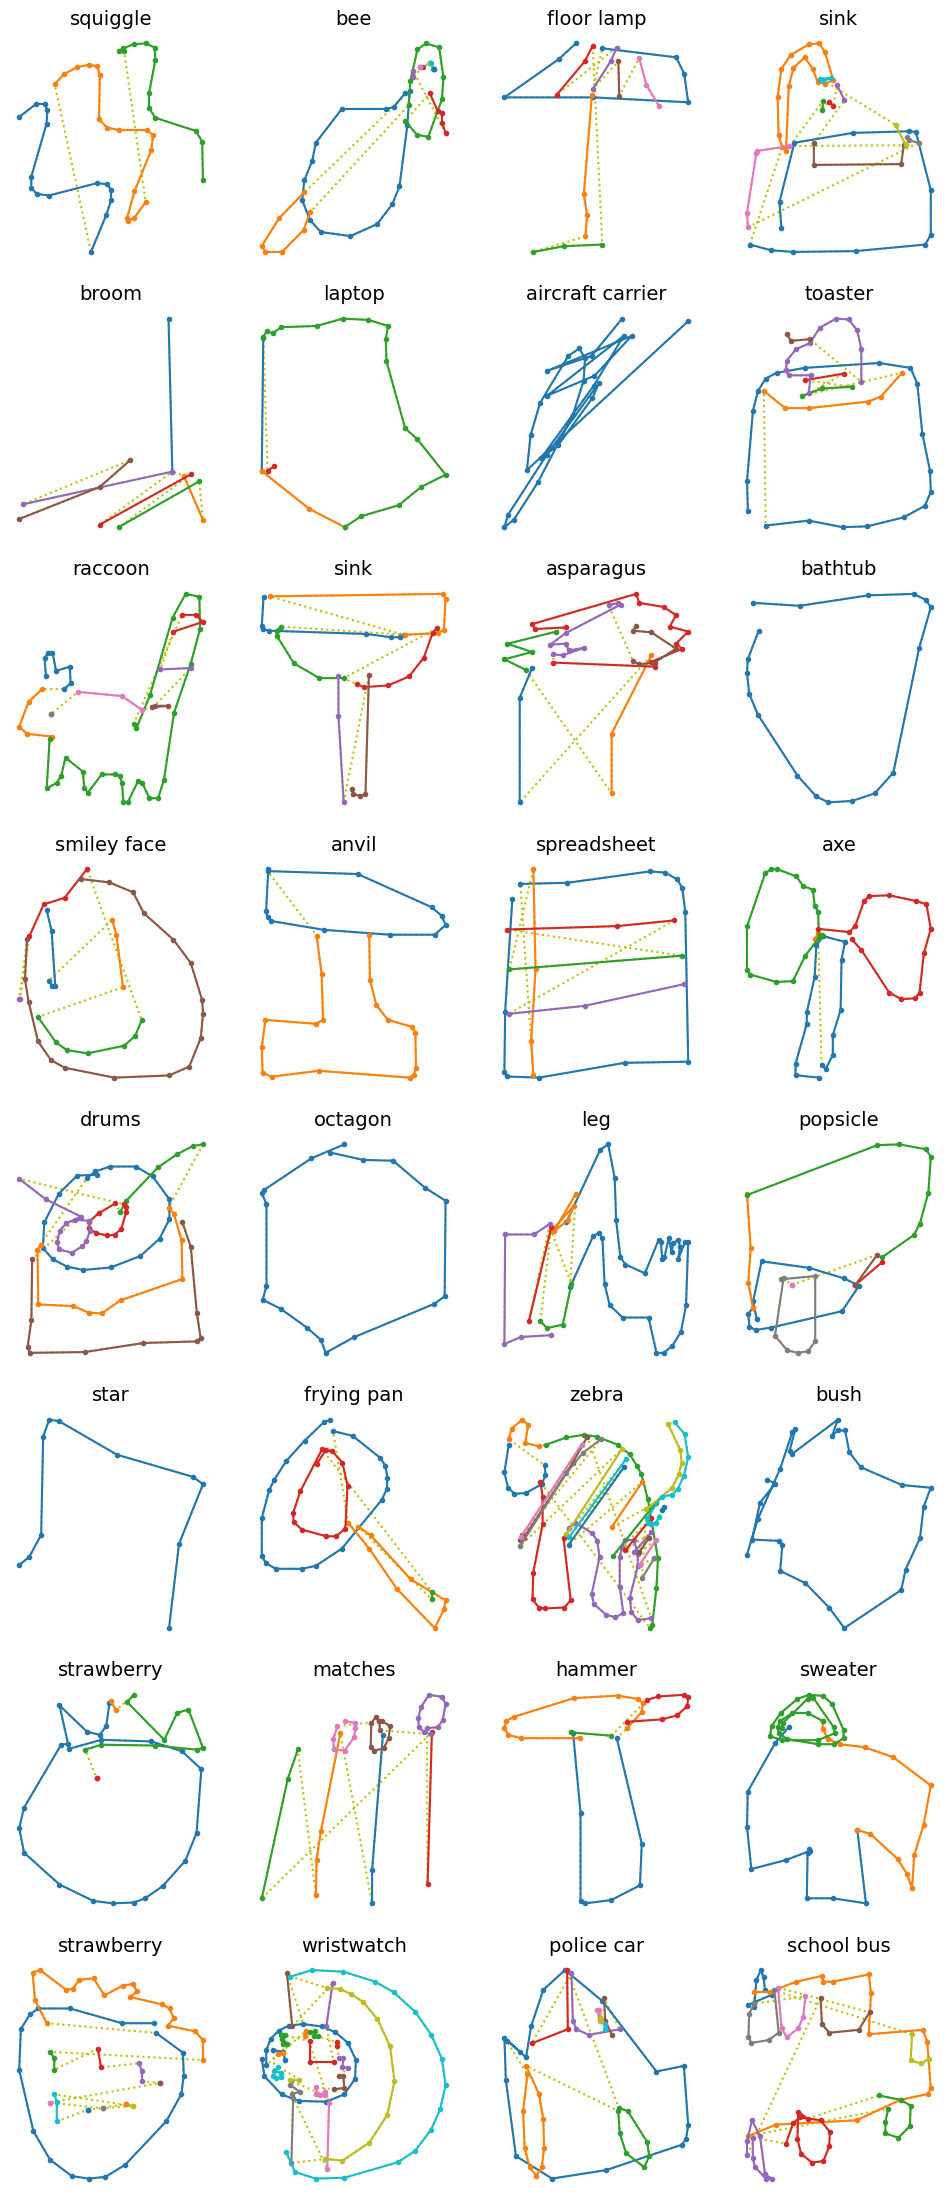

In [17]:
import numpy as np


def draw_sketch(sketch, label=None):
    origin = np.array([[0., 0., 0.]])
    sketch = np.r_[origin, sketch]
    stroke_end_indices = np.argwhere(sketch[:, -1]==1.)[:, 0]
    coordinates = sketch[:, :2].cumsum(axis=0)
    strokes = np.split(coordinates, stroke_end_indices + 1)
    title = class_names[label.numpy()] if label is not None else "Try to guess"
    plt.title(title)
    plt.plot(coordinates[:, 0], -coordinates[:, 1], "y:")
    for stroke in strokes:
        plt.plot(stroke[:, 0], -stroke[:, 1], ".-")
    plt.axis("off")

def draw_sketches(sketches, lengths, labels):
    n_sketches = len(sketches)
    n_cols = 4
    n_rows = (n_sketches - 1) // n_cols + 1
    plt.figure(figsize=(n_cols * 3, n_rows * 3.5))
    for index, sketch, length, label in zip(range(n_sketches), sketches, lengths, labels):
        plt.subplot(n_rows, n_cols, index + 1)
        draw_sketch(sketch[:length], label)
    plt.show()

for sketches, lengths, labels in train_set.take(1):
    draw_sketches(sketches, lengths, labels)

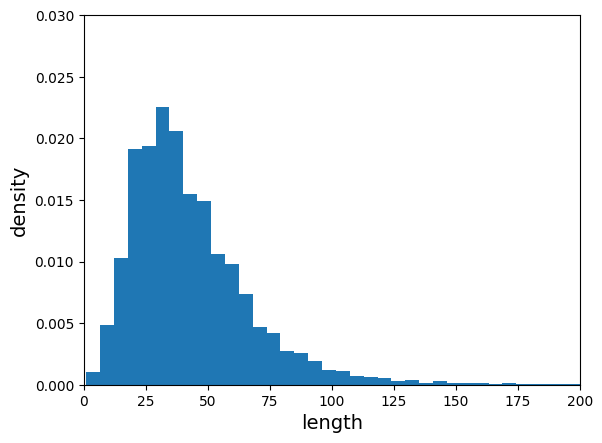

In [18]:
lengths = np.concatenate([lengths for _, lengths, _ in train_set.take(1000)])
plt.hist(lengths, bins=150, density=True)
plt.axis([0, 200, 0, 0.03])
plt.xlabel("length")
plt.ylabel("density")
plt.show()

In [19]:
def crop_long_sketches(dataset, max_length=100):
    return dataset.map(lambda inks, lengths, labels: (inks[:, :max_length], labels))

cropped_train_set = crop_long_sketches(train_set)
cropped_valid_set = crop_long_sketches(valid_set)
cropped_test_set = crop_long_sketches(test_set)

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(64, kernel_size=5, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(128, kernel_size=3, strides=2, activation="relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-2, clipnorm=1.)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy", "sparse_top_k_categorical_accuracy"])
history = model.fit(cropped_train_set, epochs=2,
                    validation_data=cropped_valid_set)

Epoch 1/2
107813/107813 [==============================] - 1839s 17ms/step - loss: 4.0941 - accuracy: 0.1672 - sparse_top_k_categorical_accuracy: 0.3711 - val_loss: 3.0968 - val_accuracy: 0.3046 - val_sparse_top_k_categorical_accuracy: 0.5901
Epoch 2/2
107813/107813 [==============================] - 12300s 114ms/step - loss: 2.7345 - accuracy: 0.3730 - sparse_top_k_categorical_accuracy: 0.6631 - val_loss: 2.5349 - val_accuracy: 0.4078 - val_sparse_top_k_categorical_accuracy: 0.6990


In [21]:
y_test = np.concatenate([labels for _, _, labels in test_set])
y_probas = model.predict(test_set)

5392/5392 [==============================] - 33s 6ms/step


In [22]:
np.mean(tf.keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_probas))

0.584508

1/1 [==============================] - 1s 834ms/step


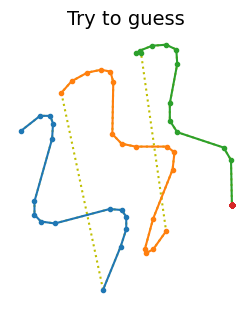

Top-5 predictions:
  1. squiggle 27.384%
  2. waterslide 14.265%
  3. snake 13.403%
  4. river 9.362%
  5. stairs 3.776%
Answer: squiggle


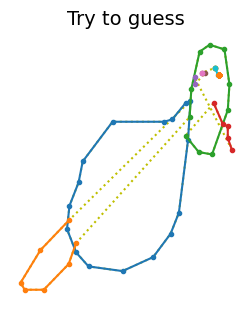

Top-5 predictions:
  1. mouse 17.108%
  2. strawberry 13.535%
  3. pig 4.504%
  4. wristwatch 4.300%
  5. sleeping bag 3.844%
Answer: bee


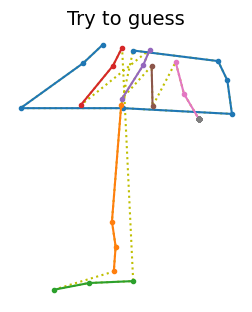

Top-5 predictions:
  1. syringe 18.441%
  2. floor lamp 17.734%
  3. microphone 4.567%
  4. drill 4.284%
  5. nail 3.941%
Answer: floor lamp


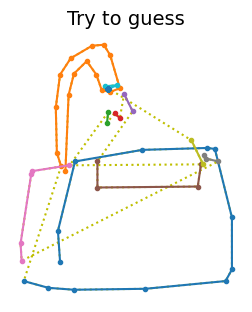

Top-5 predictions:
  1. sink 20.163%
  2. birthday cake 17.402%
  3. cake 9.509%
  4. church 6.695%
  5. toaster 5.118%
Answer: sink


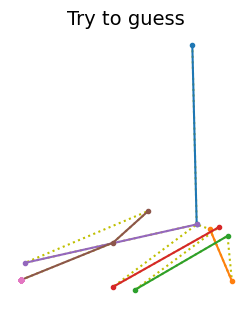

Top-5 predictions:
  1. rake 62.674%
  2. broom 21.427%
  3. stitches 4.358%
  4. ladder 1.719%
  5. leg 0.790%
Answer: broom


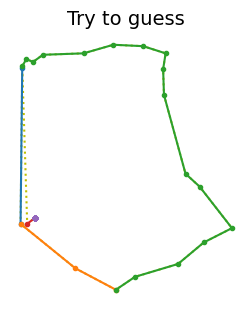

Top-5 predictions:
  1. hourglass 6.714%
  2. nose 5.923%
  3. door 5.244%
  4. cell phone 5.179%
  5. necklace 4.989%
Answer: laptop


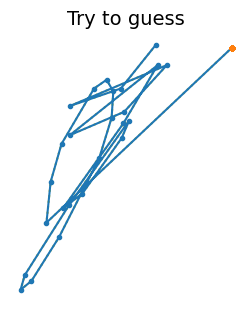

Top-5 predictions:
  1. star 30.301%
  2. lightning 17.874%
  3. zigzag 10.689%
  4. feather 4.135%
  5. asparagus 2.637%
Answer: aircraft carrier


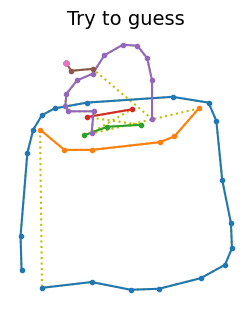

Top-5 predictions:
  1. toaster 30.182%
  2. flip flops 9.183%
  3. lighter 6.523%
  4. pineapple 6.183%
  5. sleeping bag 5.124%
Answer: toaster


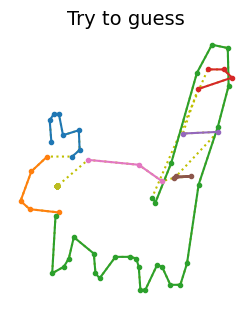

Top-5 predictions:
  1. toe 44.298%
  2. dragon 9.003%
  3. bat 5.791%
  4. guitar 2.322%
  5. light bulb 2.264%
Answer: raccoon


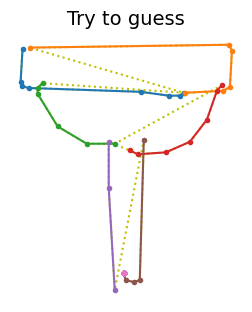

Top-5 predictions:
  1. nail 15.397%
  2. parachute 8.759%
  3. wine glass 8.494%
  4. mailbox 6.758%
  5. ice cream 6.098%
Answer: sink


In [23]:
n_new = 10
Y_probas = model.predict(sketches)
top_k = tf.nn.top_k(Y_probas, k=5)
for index in range(n_new):
    plt.figure(figsize=(3, 3.5))
    draw_sketch(sketches[index])
    plt.show()
    print("Top-5 predictions:".format(index + 1))
    for k in range(5):
        class_name = class_names[top_k.indices[index, k]]
        proba = 100 * top_k.values[index, k]
        print("  {}. {} {:.3f}%".format(k + 1, class_name, proba))
    print("Answer: {}".format(class_names[labels[index].numpy()]))